# **Machine Learning Techniques Project**


*   Nicolas Bedoya Figueroa
*   Daniel Escalante Perez
*   Marilyn Stephany Joven Fonseca
*   Eder Leandro Carbonero Baquero

In [1]:
!pip install nltk pyspellchecker tqdm emoji nlpaug transformers tensorflow xgboost[gpu] accelerate

zsh:1: no matches found: xgboost[gpu]


In [2]:
!pip install seaborn transformers torch tqdm umap-learn plotly

Defaulting to user installation because normal site-packages is not writeable


#### GRU

In [7]:
from collections import Counter
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    classification_report,
    confusion_matrix,
    roc_curve,
    auc,
    precision_recall_curve,
    average_precision_score
)
from sklearn.preprocessing import label_binarize
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GRU, Dense, Dropout
from transformers import AutoTokenizer, AutoModel

In [ ]:
# Loading embeddings from mpy
X = np.load('data/embeddings_data_glove.npy')

In [ ]:
# Loading labels from csv
df = pd.read_csv('data/balanced_data_glove.csv')
y = df['class'].to_numpy().astype(int)

assert X.shape[0] == y.shape[0], "Mismatch between embeddings and labels"


In [ ]:

# Removing classes with less than 2 items
class_counts = Counter(y)
valid_classes = {cls for cls, count in class_counts.items() if count >= 2}
mask = np.array([label in valid_classes for label in y])

X = X[mask]
y = y[mask]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)


In [ ]:

num_classes = len(np.unique(y_train))

model = Sequential([
    GRU(128, return_sequences=True, input_shape=(32, 100)),
    Dropout(0.3),
    GRU(32),
    Dropout(0.3),
    Dense(64, activation='relu'),
    Dense(num_classes, activation='sigmoid')
])

model.compile(
    loss='binary_crossentropy',
    optimizer='adam',
    metrics=['accuracy']
)


/Users/marilyn/Library/CloudStorage/OneDrive-Universidaddelosandes/ML/MLT-Project-Toxicity-Classification/env/lib/python3.9/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [106]:
history = model.fit(X_train, y_train, validation_split=0.1, epochs=100, batch_size=32)


Epoch 1/100
1130/1130 ━━━━━━━━━━━━━━━━━━━━ 12s 10ms/step - accuracy: 0.7937 - loss: 0.4171 - val_accuracy: 0.8961 - val_loss: 0.2616
Epoch 2/100
1130/1130 ━━━━━━━━━━━━━━━━━━━━ 11s 10ms/step - accuracy: 0.8909 - loss: 0.2707 - val_accuracy: 0.9049 - val_loss: 0.2359
Epoch 3/100
1130/1130 ━━━━━━━━━━━━━━━━━━━━ 11s 10ms/step - accuracy: 0.8982 - loss: 0.2460 - val_accuracy: 0.9054 - val_loss: 0.2302
Epoch 4/100
1130/1130 ━━━━━━━━━━━━━━━━━━━━ 11s 10ms/step - accuracy: 0.9056 - loss: 0.2264 - val_accuracy: 0.9064 - val_loss: 0.2216
Epoch 5/100
1130/1130 ━━━━━━━━━━━━━━━━━━━━ 11s 10ms/step - accuracy: 0.9182 - loss: 0.2006 - val_accuracy: 0.9078 - val_loss: 0.2191
Epoch 6/100
1130/1130 ━━━━━━━━━━━━━━━━━━━━ 11s 10ms/step - accuracy: 0.9256 - loss: 0.1797 - val_accuracy: 0.9156 - val_loss: 0.2158
Epoch 7/100
1130/1130 ━━━━━━━━━━━━━━━━━━━━ 11s 10ms/step - accuracy: 0.9390 - loss: 0.1493 - val_accuracy: 0.9148 - val_loss: 0.2253
Epoch 8/100
1130/1130 ━━━━━━━━━━━━━━━━━━━━ 88s 78ms/step - accuracy: 

In [ ]:
y_pred_prob = model.predict(X_test)
y_pred = np.argmax(y_pred_prob, axis=1)

print(classification_report(y_test, y_pred))


314/314 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step
              precision    recall  f1-score   support

           0       0.87      0.93      0.90      4953
           1       0.92      0.87      0.89      5084

    accuracy                           0.90     10037
   macro avg       0.90      0.90      0.90     10037
weighted avg       0.90      0.90      0.90     10037



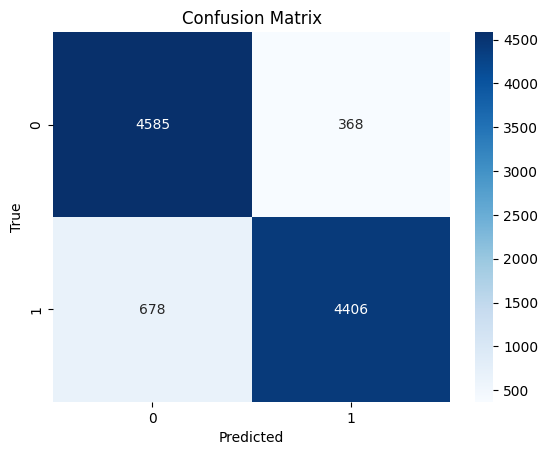

In [115]:
cm = confusion_matrix(y_test, y_pred)

sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.show()


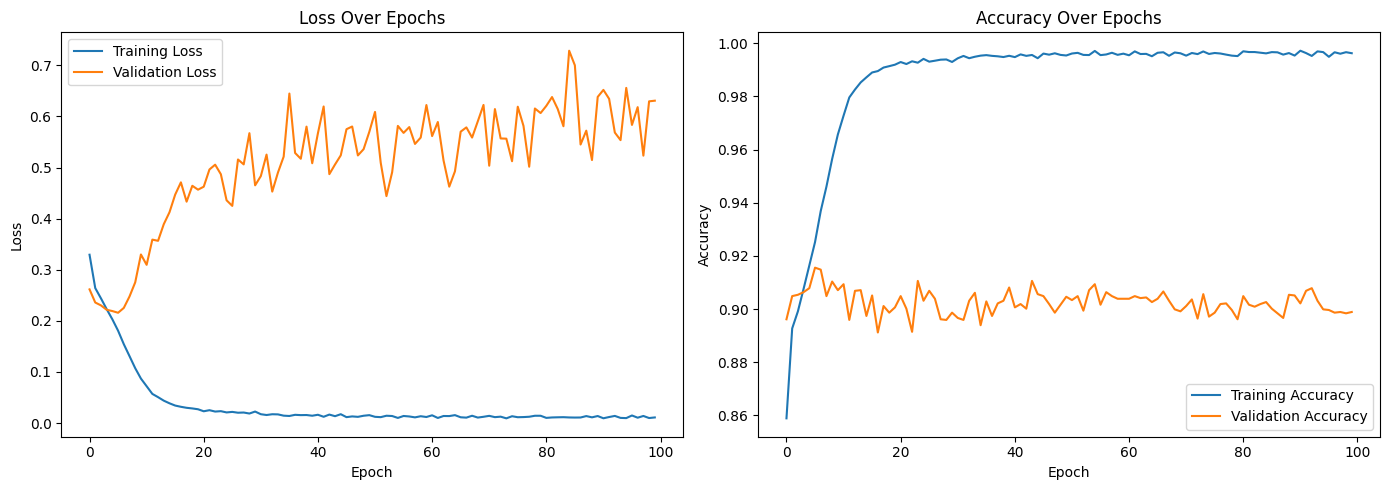

In [109]:

plt.figure(figsize=(14, 5))

plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title("Loss Over Epochs")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title("Accuracy Over Epochs")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()

plt.tight_layout()
plt.show()


In [ ]:
# Predicting class probabilities
y_pred_prob = model.predict(X_test)
y_scores = y_pred_prob.ravel()

num_classes = len(np.unique(y_test))
y_test_bin = label_binarize(y_test, classes=range(num_classes))


314/314 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step


In [83]:
print("num_classes:", num_classes)
print("y_pred_prob shape:", y_pred_prob.shape)


num_classes: 2
y_pred_prob shape: (10037, 2)


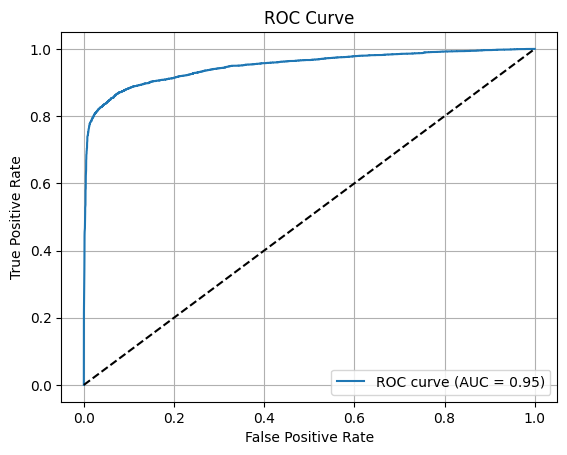

In [111]:
fpr, tpr, _ = roc_curve(y_test, y_pred_prob[:, 1])  # [:,1] = prob of positive class
roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, label=f"ROC curve (AUC = {roc_auc:.2f})")
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend()
plt.grid()
plt.show()


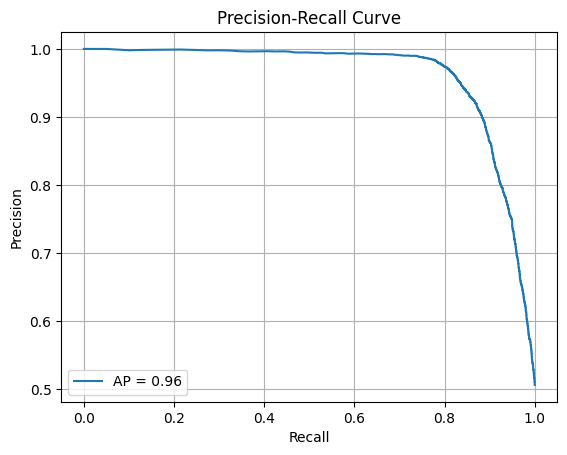

In [112]:
precision, recall, _ = precision_recall_curve(y_test, y_pred_prob[:, 1])
avg_precision = average_precision_score(y_test, y_pred_prob[:, 1])

plt.figure()
plt.plot(recall, precision, label=f"AP = {avg_precision:.2f}")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision-Recall Curve")
plt.legend()
plt.grid()
plt.show()


In [89]:
model_name = 'cardiffnlp/twitter-roberta-base'
max_len = 64

tokenizer_roberta = AutoTokenizer.from_pretrained(model_name)
model_roberta = AutoModel.from_pretrained(model_name)
model_roberta.eval()

RobertaModel(
  (embeddings): RobertaEmbeddings(
    (word_embeddings): Embedding(50265, 768, padding_idx=1)
    (position_embeddings): Embedding(514, 768, padding_idx=1)
    (token_type_embeddings): Embedding(1, 768)
    (LayerNorm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
    (dropout): Dropout(p=0.1, inplace=False)
  )
  (encoder): RobertaEncoder(
    (layer): ModuleList(
      (0-11): 12 x RobertaLayer(
        (attention): RobertaAttention(
          (self): RobertaSdpaSelfAttention(
            (query): Linear(in_features=768, out_features=768, bias=True)
            (key): Linear(in_features=768, out_features=768, bias=True)
            (value): Linear(in_features=768, out_features=768, bias=True)
            (dropout): Dropout(p=0.1, inplace=False)
          )
          (output): RobertaSelfOutput(
            (dense): Linear(in_features=768, out_features=768, bias=True)
            (LayerNorm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
            (dr

In [ ]:
input_seq = X_test[99].reshape(1, 32, 100)
pred_prob = model.predict(input_seq)[0][0]
pred_label = int(pred_prob > 0.50)
true_label = y_test[99]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


In [ ]:
indices = np.arange(len(X))
X_train, X_test, y_train, y_test, idx_train, idx_test = train_test_split(
    X, y, indices, test_size=0.2, random_state=42, stratify=y
)
original_index = idx_test[99]
tweet_text = df.iloc[original_index]['tweet']

In [ ]:
# Review examples from test
def inspect_model_decision(index, X_test, y_test, idx_test, df):
    input_seq = X_test[index].reshape(1, 32, 100)
    prob = model.predict(input_seq)[0][0]
    pred = int(prob < 0.5)
    true = y_test[index]
    original = idx_test[index]

    if isinstance(df, pd.DataFrame):
        tweet_text = df.iloc[original]['tweet']
    else:
        raise TypeError("Expected a DataFrame for df")

    print(f"\nTweet: {tweet_text}")
    print(f"True Label: {'HATE' if true else 'NOT HATE'}")
    print(f"Predicted: {'HATE' if pred else 'NOT HATE'} ({prob:.2f})")

df = pd.read_csv('data/balanced_data_glove.csv')
inspect_model_decision(55, X_test, y_test, idx_test, df)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step

Tweet: @michhelleashley who is this we..? i dont love hoes
True Label: HATE
Predicted: HATE (0.00)
